# Introduction
This notebook illustrates the dynamics between the two networks generator and discriminator of GAN, and consider why we need to train them simutaneously. 

In GAN, it is well-known that when the discriminator is freezed, the generator cannot learn to generate meaningful data because of a phenomenon called *Adverserial attack* on neural network: the generator learns to exploit the weaknesses in the limited representation capacity of the discriminator rather than learning the true distribution of the data, and the training of the discriminator is to combat with this exploitation. For that reason, we cannot use a pretrained classifier on some dataset like ImageNet to train a generator to produce similar images. 

The root for Adverserial attack is supposed to be the problem of **underfitting**; usually the discriminator belongs to a set of parameterized functions called *Hypothesis class*. Supervised learning aims at finding within this set the best function that approximates the true function that generates the data. We "approximate" the true function because it is often the case when the true function is not in this hypothesis class. This means that we spend the representation capacity of the hypothesis function to regions where data occur frequently and sacrifice the accuracy in regions that are out of distribution with the data distribution, i.e regions where data are less likely to occur. Adverserial attack is essentially the finding of these sacrificed regions.

The problem of underfitting does not go away when more data arrive, as the approximation function is not capable of perfectly representing the true function, similar to a linear function that cannot represent perfectly a quadratic function.

This notebook examines a simplified situation with GAN, where the dataset come from a circular uniform distribution over Cartesian plane, and a linear discriminator is used to simulate the Low capacity fucntion approximator. The idea is that in order for this linear function to represent a circular distribution, it needs to rotate around the boundary of the distribution, and the rotation happens when it is concurrently trained with a generator that constantly tries to exploit its weaknesses.

In [1]:
%%capture
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
!pip install celluloid
from celluloid import Camera

# Generate dataset

In [2]:
class uniformCircle(Dataset):
    '''
    Dataset that contains uniformly random datapoints in a unit circle
    '''
    def __init__(self, size=1000):
        super().__init__()
        self.size = size
        self._generate_data()
        
        
    def _generate_data(self):
        '''
        Generate a dataset with `self.size` datapoints
        '''
        self.data = []
        cnt = 0
        while cnt < self.size:
            n_points_to_generate = -cnt + self.size
            self.data.append(self._generate_points(n_points_to_generate))
            cnt += len(self.data[-1])
        self.data = np.concatenate(self.data).astype(np.float32)
        assert len(self.data) == self.size, len(self.data)
        assert self.data.shape[-1] == 2
        assert len(self.data.shape) == 2
            
    def _generate_points(self, n_point):
        '''
        Generate coordinates of datapoints uniformly inside the unit circle, 
        using rejection sampling 
        '''
        coordinates = np.random.uniform(-1, 1, n_point*2).reshape(-1, 2)
        norm = np.linalg.norm(coordinates, axis=-1)
        inside = norm < 1
        return coordinates[inside]
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, i):
        return self.data[i]
    
    def sample(self, batch_size):
        '''
        Sample `batch_size` ramdom datapoints from dataset
        '''
        assert batch_size < len(self)
        
        indx = np.random.choice(len(self), size=batch_size, replace=False)
        return self.data[indx]

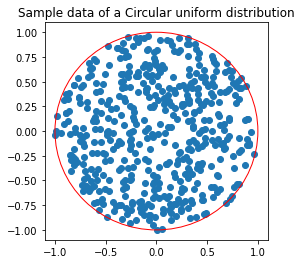

In [3]:
dataset = uniformCircle()
viz_samples = dataset.sample(500)
plt.figure(figsize=(4,4))
plt.scatter(x = viz_samples[..., 0], y = viz_samples[..., 1])
plt.gca().add_patch(plt.Circle((0, 0), 1, color='r', fill=False))
plt.title('Sample data of a Circular uniform distribution')
plt.show()

# Limited capcity discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2):
        '''
        A simple linear classifier
        '''
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 1),
          
        )
        
    def forward(self, x):
        return self.net(x)

# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_size=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 1000),
            nn.Tanh(), 
            nn.Linear(1000, 100),
            nn.Tanh(), 
            nn.Linear(100, 2)
        )
        
    def forward(self, x):
        return self.net(x)

# Train GAN

In [6]:
def weights_init_constant(m):
    '''
    Init the initial line to goes through origin, for debuging only
    '''
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        torch.nn.init.constant_(m.weight.data, 1)
        torch.nn.init.constant_(m.bias.data, .1)

In [7]:
class Visualizer:
    def __init__(self):
        self.camera = Camera(plt.figure(figsize=(10,10)))

    def add_result(self, data, gen_data, discriminator, epoch):
        if discriminator is not None:
            plt.contourf(*self.find_classifier_boundary(discriminator), cmap='RdYlGn')
        plt.scatter(x = data[..., 0], y = data[..., 1], label='Real', c='r')
        plt.scatter(x = gen_data[..., 0], y = gen_data[..., 1], label='Gen', c='b')
        plt.gca().add_patch(plt.Circle((0, 0), 1, color='g', fill=False))
        plt.xlim([-5, 5])
        plt.ylim([-5, 5])
        self.camera.snap()
        
    def find_classifier_boundary(self, discriminator):
        n_sample = 1000
        x = np.linspace(-5, 5, n_sample)
        y = np.linspace(-5, 5, n_sample)
        
        xv, yv = np.meshgrid(x, y)
        xv_, yv_ = xv.reshape(-1, 1), yv.reshape(-1, 1)
        check_points = np.concatenate([xv_, yv_], axis=-1).astype(np.float32)
        input = torch.from_numpy(check_points)
        with torch.no_grad():
            output = discriminator(input).view(n_sample, n_sample)
        return xv, yv, output
    
    def animate(self):
        anim = self.camera.animate()
        anim.save('training_trajectory.mp4')
        def show_video():
            import glob
            import io
            import base64
            from IPython.display import HTML
            from IPython import display as ipythondisplay
            mp4list = glob.glob('*.mp4')
            if len(mp4list) > 0:
                mp4 = mp4list[0]
                video = io.open(mp4, 'r+b').read()
                encoded = base64.b64encode(video)
                ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                      loop controls style="height: 300px;">
                      <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                      </video>'''.format(encoded.decode('ascii'))))
            else: 
                print("Could not find video")
        show_video()
        plt.clf()
#         %rm -r video

In [8]:
def train_GAN():
    # Loss function
    adversarial_loss = torch.nn.BCEWithLogitsLoss()

    # Initialize generator and discriminator
    generator = Generator()
    discriminator = Discriminator()

    discriminator.apply(weights_init_constant)
    # generator.apply(weights_init_constant)

    optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-2)

    # Dataloader
    dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

    # Visualizer
    visualizer = Visualizer()

    for _ in range(20):
        for data in dataloader:
            # Adversarial ground truths
            valid = torch.from_numpy(np.ones((data.shape[0], 1)).astype(np.float32))
            fake = torch.from_numpy(np.zeros((data.shape[0], 1)).astype(np.float32))

            # Generate fake datapoints
            z = torch.from_numpy(np.random.normal(0, 5, (data.shape[0], 2)).astype(np.float32))
            gen_data = generator(z)

            # Loss measures generator's ability to fool the discriminator
            g_loss = adversarial_loss(discriminator(gen_data), valid)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()


            # Measure discriminator's ability to classify real from generated samples
            real_loss = adversarial_loss(discriminator(data), valid)
            fake_loss = adversarial_loss(discriminator(gen_data.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2

            optimizer_D.zero_grad()
            d_loss.backward()
            optimizer_D.step()

            # Save result for visualizing
            visualizer.add_result(data, gen_data.detach(), discriminator, 0)
    print('Done training!...')
    visualizer.animate();

In [9]:
train_GAN()

Done training!...


<Figure size 720x720 with 0 Axes>

The generator generates fake datapoints that looks real in the eyes of the discriminator. When the discriminator is linear, the decision landscape of the discriminator is a steeped, flat plane. In the visualization, red region means the realness is low and green color denotes regions that seems real, and the generator will try to bring the generated data (blue dots) to the green regions. We can see that, when the discriminator is freezed, blue dots will simply goes perpendicularly with the decision boundary to the green areas, but these green areas can be very far away from the data regions, illustrating the flaws in the data representation of the discriminator.

Throughout the training, observe that at some points when the generated data climb too far to the green regions, the decision boundary rotates around, making fake data inside the red regions.


# Train GAN when the discriminator is freezed

In [10]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

discriminator.apply(weights_init_constant)
# generator.apply(weights_init_constant)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-2)

# Dataloader
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

# Visualizer
visualizer = Visualizer()

for _ in range(20):
    for data in dataloader:
        # Adversarial ground truths
        valid = torch.from_numpy(np.ones((data.shape[0], 1)).astype(np.float32))
        fake = torch.from_numpy(np.zeros((data.shape[0], 1)).astype(np.float32))
        
        # Generate fake datapoints
        z = torch.from_numpy(np.random.normal(0, 5, (data.shape[0], 2)).astype(np.float32))
        gen_data = generator(z)
        
        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_data), valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
        
        # Save result for visualizing
        visualizer.add_result(data, gen_data.detach(), discriminator, 0)
print('Done training!...')
visualizer.animate();

Done training!...


<Figure size 720x720 with 0 Axes>

# Train GAN with more powerful discriminator

The requirement of simultaneously training two networks boils down to how to combat agaist adverserial attacks, for example using more expressive models. In the following experiments, two model architectures are used: the first one is with a deep MLP network with Tanh activation function and the second is a normal neural net with quadratic input. 

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2):
        '''
        MLP classifier with Tanh activation functions
        '''
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 100),
            nn.Tanh(),
            nn.Linear(100, 1),
        )
        
    def forward(self, x):
        return self.net(x)

In [12]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# discriminator.apply(weights_init_constant)
# generator.apply(weights_init_constant)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-2)

# Dataloader
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

# Visualizer
visualizer = Visualizer()

for _ in range(20):
    for data in dataloader:
        # Adversarial ground truths
        valid = torch.from_numpy(np.ones((data.shape[0], 1)).astype(np.float32))
        fake = torch.from_numpy(np.zeros((data.shape[0], 1)).astype(np.float32))

        # Generate fake datapoints
        z = torch.from_numpy(np.random.normal(0, 5, (data.shape[0], 2)).astype(np.float32))
        gen_data = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_data), valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(data), valid)
        fake_loss = adversarial_loss(discriminator(gen_data.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Save result for visualizing
        visualizer.add_result(data, gen_data.detach(), discriminator, 0)
print('Done training!...')
visualizer.animate();

Done training!...


<Figure size 720x720 with 0 Axes>

In [13]:
class Discriminator(nn.Module):
    def __init__(self, input_size=2):
        '''
        quadratic MLP classifier 
        '''
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size**2, 100),
            nn.Tanh(),
            nn.Linear(100, 1),
        )
        
    def forward(self, x):
        with torch.no_grad():
            x = x.unsqueeze(-1) * x.unsqueeze(-2)
        return self.net(x.flatten(-2))

In [14]:
# Loss function
adversarial_loss = torch.nn.BCEWithLogitsLoss()

# Initialize generator and discriminator
generator = Generator()
discriminator = Discriminator()

# discriminator.apply(weights_init_constant)
# generator.apply(weights_init_constant)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=5e-2)

# Dataloader
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

# Visualizer
visualizer = Visualizer()

for _ in range(20):
    for data in dataloader:
        # Adversarial ground truths
        valid = torch.from_numpy(np.ones((data.shape[0], 1)).astype(np.float32))
        fake = torch.from_numpy(np.zeros((data.shape[0], 1)).astype(np.float32))

        # Generate fake datapoints
        z = torch.from_numpy(np.random.normal(0, 5, (data.shape[0], 2)).astype(np.float32))
        gen_data = generator(z)

        # Loss measures generator's ability to fool the discriminator
        g_loss = adversarial_loss(discriminator(gen_data), valid)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()


        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(data), valid)
        fake_loss = adversarial_loss(discriminator(gen_data.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Save result for visualizing
        visualizer.add_result(data, gen_data.detach(), discriminator, 0)
print('Done training!...')
visualizer.animate();

Done training!...


<Figure size 720x720 with 0 Axes>

# Train GAN with Optimal transport as loss function

In the paper [IMPROVING GANS USING OPTIMAL TRANSPORT](https://arxiv.org/abs/1803.05573), the author demonstrated that we can train GAN using Sinkhorn distance that retains the performance of the generator even when the discriminator is freezed. This experiment is aimed at testing that statement by removing the discriminator and using OT only as loss function.

In [15]:
# This code is a modifed version from https://github.com/gpeyre/SinkhornAutoDiff/blob/master/sinkhorn_pointcloud.py
from torch.autograd import Variable

def sinkhorn_loss(x, y, epsilon, n, niter):
    """
    Given two emprical measures with n points each with locations x and y
    outputs an approximation of the OT cost with regularization parameter epsilon
    niter is the max. number of steps in sinkhorn loop
    """

    # The Sinkhorn algorithm takes as input three variables :
    C = cost_matrix(x, y)  # Wasserstein cost function

    # both marginals are fixed with equal weights
    # mu = Variable(1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    # nu = Variable(1. / n * torch.cuda.FloatTensor(n).fill_(1), requires_grad=False)
    mu = Variable(1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)
    nu = Variable(1. / n * torch.FloatTensor(n).fill_(1), requires_grad=False)

    # Parameters of the Sinkhorn algorithm.
    rho = 1  # (.5) **2          # unbalanced transport
    tau = -.8  # nesterov-like acceleration
    lam = rho / (rho + epsilon)  # Update exponent
    thresh = 10**(-1)  # stopping criterion

    # Elementary operations .....................................................................
    def ave(u, u1):
        "Barycenter subroutine, used by kinetic acceleration through extrapolation."
        return tau * u + (1 - tau) * u1

    def M(u, v):
        "Modified cost for logarithmic updates"
        "$M_{ij} = (-c_{ij} + u_i + v_j) / \epsilon$"
        return (-C + u.unsqueeze(1) + v.unsqueeze(0)) / epsilon

    def lse(A):
        "log-sum-exp"
        return torch.log(torch.exp(A).sum(1, keepdim=True) + 1e-6)  # add 10^-6 to prevent NaN

    # Actual Sinkhorn loop ......................................................................
    u, v, err = 0. * mu, 0. * nu, 0.
    actual_nits = 0  # to check if algorithm terminates because of threshold or max iterations reached

    for i in range(niter):
        u1 = u  # useful to check the update
        u = epsilon * (torch.log(mu) - lse(M(u, v)).squeeze()) + u
        v = epsilon * (torch.log(nu) - lse(M(u, v).t()).squeeze()) + v
        # accelerated unbalanced iterations
        # u = ave( u, lam * ( epsilon * ( torch.log(mu) - lse(M(u,v)).squeeze()   ) + u ) )
        # v = ave( v, lam * ( epsilon * ( torch.log(nu) - lse(M(u,v).t()).squeeze() ) + v ) )
        err = (u - u1).abs().sum()

        actual_nits += 1
        if (err < thresh).data.numpy():
            break
    U, V = u, v
    pi = torch.exp(M(U, V))  # Transport plan pi = diag(a)*K*diag(b)
    cost = torch.sum(pi * C)  # Sinkhorn cost

    return cost


def cost_matrix(x, y, p=2):
    "Returns the matrix of $|x_i-y_j|^p$."
    x_col = x.unsqueeze(1)
    y_lin = y.unsqueeze(0)
    c = torch.sum((torch.abs(x_col - y_lin)) ** p, 2)
    return c

In [16]:
# Initialize generator
generator = Generator()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=2e-4)

# Visualizer
visualizer = Visualizer()

# Dataloader
dataloader = DataLoader(dataset, batch_size = 64, shuffle = True)

# Sinkhorn parameters
epsilon = 0.01
niter = 100

for _ in range(20):
    for data in dataloader:
        # Generate fake datapoints
        z = torch.from_numpy(np.random.normal(0, 5, (data.shape[0], 2)).astype(np.float32))
        gen_data = generator(z)
        
        g_loss = sinkhorn_loss(gen_data, data, epsilon, data.shape[0] ,niter)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
        # Save result for visualizing
        visualizer.add_result(data, gen_data.detach(), None, 0)
print('Done training!...')
visualizer.animate();

Done training!...


<Figure size 720x720 with 0 Axes>

Since the OT GAN minimizes the Optimal transport between the generated data and the real data, we cannot visualize the decision boundary of the real-fake data. But the results obtained from this seems to be better than from other experiments as generated data scatter quite evenly inside the circle (notice that in some experiments the generated data sometimes clusters around a small region, this might coresspond to one of the two collapse modes of GAN). In this experiment we do not use a discriminator but directly compare and minimize the distances, in practice the data is usually projected onto a latent space and the distance is computed in this space. The discriminator in this case is not really a discriminator but a feature extractor that maps data to learned feature space where real and fake data are far apart from each other in terms of the distance metric used. Thus it can still work even when this feature mapping is freezed.

Final thought: inspired from this, can we devise new types of network architecture that are robust against adversarial attacks? Another network architecture that is robust to adverserial attack, the RBF net, is also based on some kind of distance functions, but training RBF is too hard since the gradient from RBFs is generally close to zero most of the time. In fact, adverserial attack methods are mostly based on gradient ascent on the direction of the attacked class, which is basically the same method that we use to optimize the model; gradient descend. As a result, making it harder to do adverserial attack will generally lead to harder tranining time. Unless our hypothesis class contains functions that faithfully represent the true generating function, then adverserial attack will persist. In that regard, employing distance function, in my opinion, might be the right direction to head to.